<img src='https://i.imgur.com/RDAD11M.png' width = '200' align = 'right'>

# 📝  Project2

**파워 리프팅 대회에 도전한다고 가정한다.** 

역대 파워리프팅 대회 참가자들의 기록을 활용하여 현재 나 (혹은 신청 고객)의 위치 를 알아보고, `파워리프팅 대회에서 높은 성적을 따내기 위해` 어떤 전략을 취해야 하는지, `현재 실력으로 입상 가능성이 존재하는지` 알아본다.


1. 힘은 체중에 어느정도 비례한다고 생각된다. 적정 체중을 어느정도로 유지해야 좋은 성적을 낼 수 있는가?
2. 최고의 성적을 내는 선수들의 나이대는 어느정도인가? 이미 늦어 버린것은 아닌지?
3. Raw 파워리프팅(무장비) 과 장비를 착용하는 파워리프팅 둘 중 어느대회에 참여하는것이 적절한가?
4. 비교적 상위 클래스에 들기 쉬운 대회부터 참가하고자 할때, 어느 국가의 어느 대회부터 도전하는 것이 바람직한가?
5. 성적에 영향을 주는 요소들은 무엇이고 스테로이드를 사용했을 경우 어느정도 기록향상이 기대되는가? 어느정도 강해지는가?
6. 현재 운동실력으로 대회에 출전할 시 어느정도의 성적이 예상되는가?

## **파일 가져오기 및 import**

In [5]:
!pip install category_encoders 
!pip install eli5 
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 15.8 MB/s 
     |████████████████████████████████| 133 kB 53.3 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c4138e9c52b965a20a90ed1ae824aec512706b8f350111b04750bdb9aae96343
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requi

In [6]:
import pandas as pd
import numpy as np
import re
from google.colab import files
import io
import matplotlib.pyplot as plt 
import random
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from pdpbox.pdp import pdp_isolate, pdp_plot #  pdp plot 그리기 

In [7]:
df = pd.read_csv('powerlifting.csv')

In [8]:
df.shape

(1423354, 37)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 37 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Event            1423354 non-null  object 
 3   Equipment        1423354 non-null  object 
 4   Age              757527 non-null   float64
 5   AgeClass         786800 non-null   object 
 6   Division         1415176 non-null  object 
 7   BodyweightKg     1406622 non-null  float64
 8   WeightClassKg    1410042 non-null  object 
 9   Squat1Kg         337580 non-null   float64
 10  Squat2Kg         333349 non-null   float64
 11  Squat3Kg         323842 non-null   float64
 12  Squat4Kg         3696 non-null     float64
 13  Best3SquatKg     1031450 non-null  float64
 14  Bench1Kg         499779 non-null   float64
 15  Bench2Kg         493486 non-null   float64
 16  Bench3Kg         4

## **특성 정리하기**

---



Feature가 37개로 너무 많다. 필요한 특성만을 추려내고 이름을 변경한다.

In [10]:
df = df.drop(columns=['AgeClass', 'Division','McCulloch','Glossbrenner','IPFPoints','Date','Federation','MeetState','Squat1Kg','Squat2Kg','Squat3Kg','Squat4Kg','Bench1Kg','Bench2Kg','Bench3Kg','Bench4Kg','Deadlift1Kg','Deadlift2Kg','Deadlift3Kg','Deadlift4Kg',
                      'WeightClassKg'])

In [11]:
df = df.drop(columns=['Place','Country'])

In [12]:
df.rename(columns={'Event':'isSBD','Best3SquatKg':'Squat','Best3BenchKg':'Bench','Best3DeadliftKg':'Dead'}, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Name          1423354 non-null  object 
 1   Sex           1423354 non-null  object 
 2   isSBD         1423354 non-null  object 
 3   Equipment     1423354 non-null  object 
 4   Age           757527 non-null   float64
 5   BodyweightKg  1406622 non-null  float64
 6   Squat         1031450 non-null  float64
 7   Bench         1276181 non-null  float64
 8   Dead          1081808 non-null  float64
 9   TotalKg       1313184 non-null  float64
 10  Wilks         1304407 non-null  float64
 11  Tested        1093892 non-null  object 
 12  MeetCountry   1423354 non-null  object 
 13  MeetName      1423354 non-null  object 
dtypes: float64(7), object(7)
memory usage: 152.0+ MB


In [14]:
df.shape

(1423354, 14)

###**데이터 설명**

```
data size: (1423354, 14)

Name          : 이름
Sex           : 성별
isSBD         : 참여 종목 종류
Equipment     : 장비 착용 종류
Age           : 나이
BodyweightKg  : 체중
Squat         : 스쿼트 중량
Bench         : 벤치프레스 중량
Dead          : 데드리프트 중량
TotalKg       : 총 중량 합
Wilks         : Wilks 점수 ( 체중대비,성별대비 총 중량의 점수 값)
Tested        : 도핑테스트 검출 여부
MeetCountry   : 개최 국가
MeetName      : 대회 명
```

## **전처리**

In [15]:
DF = df.copy()

In [16]:
DF.head(5)

,Name,Sex,isSBD,Equipment,Age,BodyweightKg,Squat,Bench,Dead,TotalKg,Wilks,Tested,MeetCountry,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,59.8,105.0,55.0,130.0,290.0,324.16,NaN,Australia,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,58.5,120.0,67.5,145.0,332.5,378.07,NaN,Australia,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,55.4,NaN,32.5,NaN,32.5,38.56,NaN,Australia,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,60.0,105.0,72.5,132.5,310.0,345.61,NaN,Australia,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,104.0,140.0,80.0,170.0,390.0,321.25,NaN,Australia,Melbourne Cup


In [17]:
DF.shape

(1423354, 14)

**전처리**

1. 중복값 제거
2. 일부 종목만 참가한 참가자들은 평가에서 제외 (isSBD 에서 SBD row만 남김)
3. Squat, Bench, Dead 중 주어진 모든 도전횟수에서 실패한 참가자는 결측치 발생으로 제외한다.
4. 총 중량과 Wilk 점수에서 null 값이 발생한 경우 제거
5. 나이가 적혀있지 않은 참가자도 제거
6. 도핑 테스트 결과가 양성이면 1, 음성이면(NaN) 0으로 표시한다.

In [18]:
DF = DF.drop_duplicates() # 52595 개

In [19]:
DF.shape

(1370759, 14)

In [20]:
DF = DF.dropna(subset=['Squat', 'Bench', 'Dead','TotalKg','Wilks','Age']) # the same with dropna(axis=0)

In [21]:
DF.shape

(445363, 14)

In [22]:
DF

,Name,Sex,isSBD,Equipment,Age,BodyweightKg,Squat,Bench,Dead,TotalKg,Wilks,Tested,MeetCountry,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,59.80,105.0,55.0,130.0,290.0,324.16,NaN,Australia,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,58.50,120.0,67.5,145.0,332.5,378.07,NaN,Australia,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,60.00,105.0,72.5,132.5,310.0,345.61,NaN,Australia,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,104.00,140.0,80.0,170.0,390.0,321.25,NaN,Australia,Melbourne Cup
5,April Alvarez,F,SBD,Wraps,37.0,74.00,142.5,82.5,145.0,370.0,354.74,NaN,Australia,Melbourne Cup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423345,Łukasz Głowacz,M,SBD,Raw,40.5,82.75,170.0,130.0,200.0,500.0,334.35,Yes,Poland,Polish Classic Powerlifting Cup
1423347,Adam Jasiński,M,SBD,Raw,65.5,78.00,215.0,115.0,207.5,537.5,372.98,Yes,Poland,Polish Classic Powerlifting Cup
1423349,Marian Cafalik,M,SBD,Raw,60.5,73.50,175.0,87.5,190.0,452.5,327.07,Yes,Poland,Polish Classic Powerlifting Cup
1423350,Marian Piwowarczyk,M,SBD,Raw,55.5,63.50,110.0,95.0,170.0,375.0,304.16,Yes,Poland,Polish Classic Powerlifting Cup


In [23]:
DF_notSBD = DF[DF['isSBD'] != 'SBD'].index

In [24]:
DF_notSBD # 결측치 없애는 위 과정에서 일부 운동만 한 경우도 자연스럽게 없어진듯 함

Int64Index([], dtype='int64')

In [25]:
DF.Tested.replace({np.nan : 0, 'Yes' : 1},inplace=True) # 도핑 여부 표시 변경

In [26]:
DF.reset_index(drop=True) # index 최종 정렬

,Name,Sex,isSBD,Equipment,Age,BodyweightKg,Squat,Bench,Dead,TotalKg,Wilks,Tested,MeetCountry,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,59.80,105.0,55.0,130.0,290.0,324.16,0,Australia,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,58.50,120.0,67.5,145.0,332.5,378.07,0,Australia,Melbourne Cup
2,Amy Moldenhauer,F,SBD,Wraps,23.0,60.00,105.0,72.5,132.5,310.0,345.61,0,Australia,Melbourne Cup
3,Andrea Rowan,F,SBD,Wraps,45.0,104.00,140.0,80.0,170.0,390.0,321.25,0,Australia,Melbourne Cup
4,April Alvarez,F,SBD,Wraps,37.0,74.00,142.5,82.5,145.0,370.0,354.74,0,Australia,Melbourne Cup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445358,Łukasz Głowacz,M,SBD,Raw,40.5,82.75,170.0,130.0,200.0,500.0,334.35,1,Poland,Polish Classic Powerlifting Cup
445359,Adam Jasiński,M,SBD,Raw,65.5,78.00,215.0,115.0,207.5,537.5,372.98,1,Poland,Polish Classic Powerlifting Cup
445360,Marian Cafalik,M,SBD,Raw,60.5,73.50,175.0,87.5,190.0,452.5,327.07,1,Poland,Polish Classic Powerlifting Cup
445361,Marian Piwowarczyk,M,SBD,Raw,55.5,63.50,110.0,95.0,170.0,375.0,304.16,1,Poland,Polish Classic Powerlifting Cup


In [27]:
str_expr = "Age <= 11"     # 나이가 11<=이다 (비교연산자 >=)
DF_q = DF.query(str_expr).index  # 조건 부합 데이터 추출

In [28]:
DF_q

Int64Index([  22223,   22729,   25985,   26805,   28337,   28566,   32884,
              32887,   35837,   35839,
            ...
            1405393, 1407318, 1407319, 1408296, 1414214, 1414223, 1414294,
            1414681, 1414783, 1422369],
           dtype='int64', length=705)

In [29]:
DF = DF.drop(DF_q).reset_index(drop=True)

In [30]:
DF.shape # 전처리 끝나고 최종 정리된 사이즈

(444658, 14)

In [31]:
DF

,Name,Sex,isSBD,Equipment,Age,BodyweightKg,Squat,Bench,Dead,TotalKg,Wilks,Tested,MeetCountry,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,59.80,105.0,55.0,130.0,290.0,324.16,0,Australia,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,58.50,120.0,67.5,145.0,332.5,378.07,0,Australia,Melbourne Cup
2,Amy Moldenhauer,F,SBD,Wraps,23.0,60.00,105.0,72.5,132.5,310.0,345.61,0,Australia,Melbourne Cup
3,Andrea Rowan,F,SBD,Wraps,45.0,104.00,140.0,80.0,170.0,390.0,321.25,0,Australia,Melbourne Cup
4,April Alvarez,F,SBD,Wraps,37.0,74.00,142.5,82.5,145.0,370.0,354.74,0,Australia,Melbourne Cup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444653,Łukasz Głowacz,M,SBD,Raw,40.5,82.75,170.0,130.0,200.0,500.0,334.35,1,Poland,Polish Classic Powerlifting Cup
444654,Adam Jasiński,M,SBD,Raw,65.5,78.00,215.0,115.0,207.5,537.5,372.98,1,Poland,Polish Classic Powerlifting Cup
444655,Marian Cafalik,M,SBD,Raw,60.5,73.50,175.0,87.5,190.0,452.5,327.07,1,Poland,Polish Classic Powerlifting Cup
444656,Marian Piwowarczyk,M,SBD,Raw,55.5,63.50,110.0,95.0,170.0,375.0,304.16,1,Poland,Polish Classic Powerlifting Cup


In [32]:
'''
valid_Year = "Year>1950 & Year<2050"
DF = DF.query(valid_Year)

DF.Year = DF.Year.astype('int')  # int형으로 변경

NotPub = DF[~DF['Publisher'].str.contains(r'[A-Za-z]')].index # 알파벳을 포함하지 않는 데이터 제거

# file export
file_name = 'sample1.csv'
# saving the excelsheet
DF.to_csv(file_name, index=False)
'''

'\nvalid_Year = "Year>1950 & Year<2050"\nDF = DF.query(valid_Year)\n\nDF.Year = DF.Year.astype(\'int\')  # int형으로 변경\n\nNotPub = DF[~DF[\'Publisher\'].str.contains(r\'[A-Za-z]\')].index # 알파벳을 포함하지 않는 데이터 제거\n\n# file export\nfile_name = \'sample1.csv\'\n# saving the excelsheet\nDF.to_csv(file_name, index=False)\n'

## **EDA**

**target = Wilks**

단순 중량의 합은 남성일수록, 체격(체중)이 클수록 높아지므로 체급에 큰 영향을 받아 객관적인 강함의 지표로 이용하기 어려움.

따라서 Wilks score를 이용한다.

계산 공식은 다음과 같다.

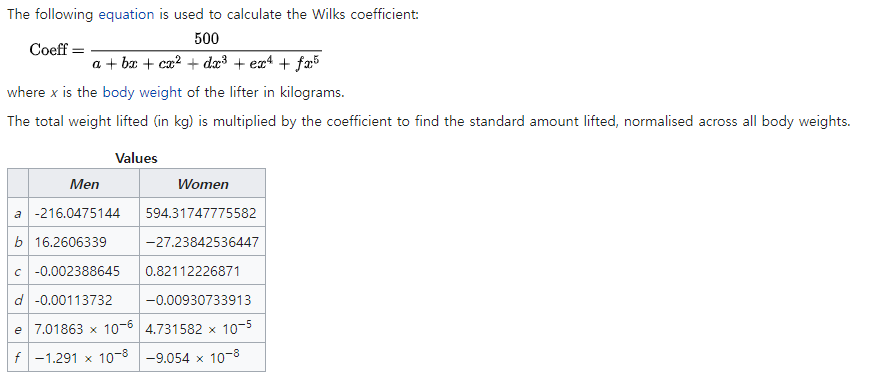

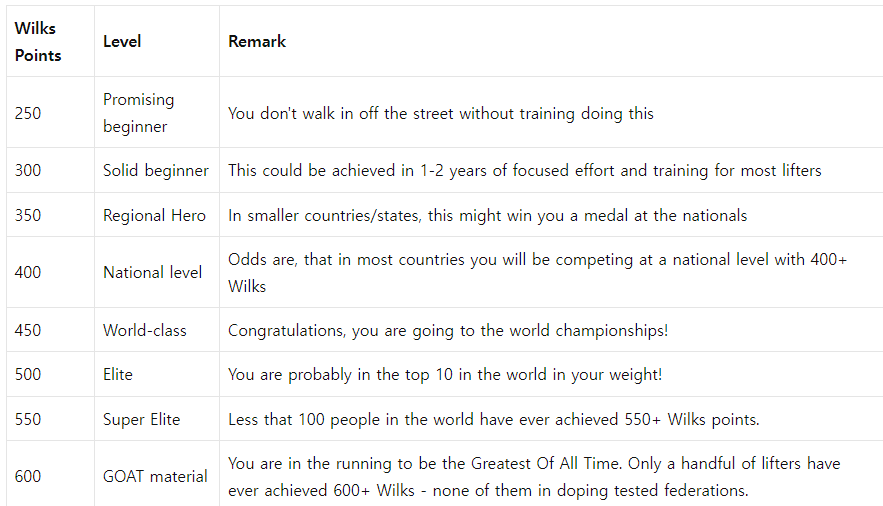

Wilks 점수는 **초보자의 경우 250** 정도이며

지역에서 한가닥 하는 사람은 350 정도,

**슈퍼 엘리트 선수의 경우에 550~**의 값이 나온다고 보면 된다. 

### **가설**

가설1. 미성년자가 아니라면, 나이가 어릴 수록 (젊을 수록) 높은 성적을 낼 수 있다. 40대가 넘어가면 성적 하락이 보일 것이다.

가설2. 장비를 착용하는 파워리프팅은 높은 체중을 가진 사람들에게 더 유리할 것이다.

가설3. 스테로이드를 사용한 사람들의 성적이 그렇지 않은 사람들보다 월등히 높을 것이다.




1. wilks 점수의 분포는 정규분포를 그린다. 

Text(0.5, 1.0, 'Wilks Distribution')

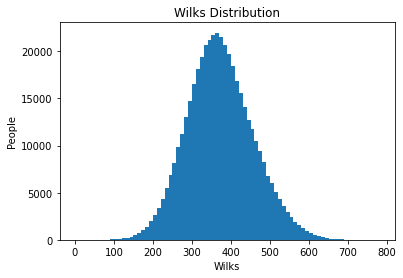

In [33]:
bin_size=10      # bin -> 8 setting
plt.hist(DF['Wilks'], np.arange(0,df.Wilks.max()+bin_size, bin_size))
plt.xlabel('Wilks')
plt.ylabel('People')
plt.title('Wilks Distribution')

In [34]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444658 entries, 0 to 444657
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Name          444658 non-null  object 
 1   Sex           444658 non-null  object 
 2   isSBD         444658 non-null  object 
 3   Equipment     444658 non-null  object 
 4   Age           444658 non-null  float64
 5   BodyweightKg  444658 non-null  float64
 6   Squat         444658 non-null  float64
 7   Bench         444658 non-null  float64
 8   Dead          444658 non-null  float64
 9   TotalKg       444658 non-null  float64
 10  Wilks         444658 non-null  float64
 11  Tested        444658 non-null  int64  
 12  MeetCountry   444658 non-null  object 
 13  MeetName      444658 non-null  object 
dtypes: float64(7), int64(1), object(6)
memory usage: 47.5+ MB


In [35]:
DF['Age'].max()

95.5

Text(0.5, 1.0, 'Age Distribution')

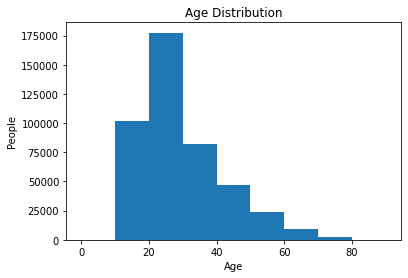

In [36]:
bin_size=10     # bin -> 8 setting
plt.hist(DF['Age'], np.arange(0,100, bin_size))
plt.xlabel('Age')
plt.ylabel('People')
plt.title('Age Distribution')

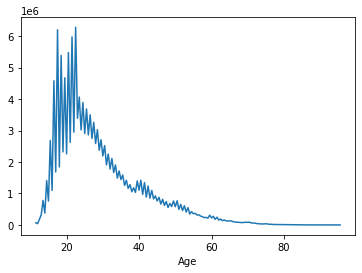

In [37]:
DF.groupby('Age')['Wilks'].sum().plot()

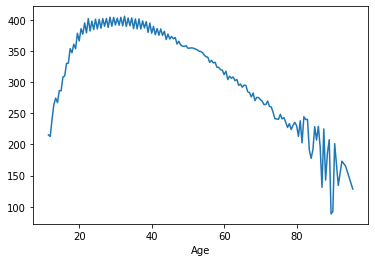

In [38]:
DF.groupby('Age')['Wilks'].mean().plot()
#plt.ylabel('Wilk Score')

In [89]:
DF.loc[:,'Age']

0         29.0
1         29.0
2         23.0
3         45.0
4         37.0
          ... 
444653    40.5
444654    65.5
444655    60.5
444656    55.5
444657    62.5
Name: Age, Length: 444658, dtype: float64

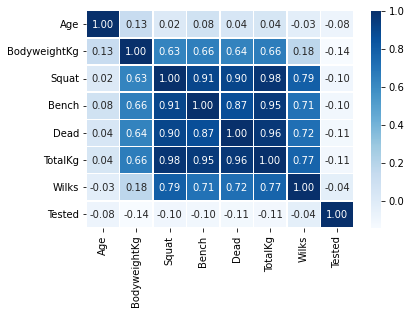

In [100]:
DF_cor1 = DF
sns.heatmap(data = DF.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

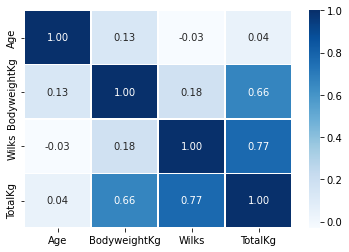

In [97]:
#plt.figure(figsize=(15,15))
DF_cor1 = DF.loc[:,['Age','BodyweightKg','Wilks','TotalKg']]
sns.heatmap(data = DF_cor1.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

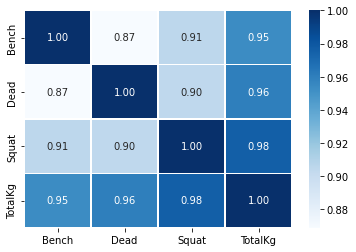

In [99]:

DF_cor2 = DF.loc[:,['Bench','Dead','Squat','TotalKg']]
sns.heatmap(data = DF_cor2.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [ ]:
'''
str_expr = "Age <= 11"     # 나이가 11<=이다 (비교연산자 >=)
DF_q = DF.query(str_expr).index  # 조건 부합 데이터 추출
DF = DF.drop(DF_q).reset_index(drop=True)
'''

ㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁㅁ

In [62]:
DF['Tested'].value_counts(normalize=True)

1    0.715336
0    0.284664
Name: Tested, dtype: float64

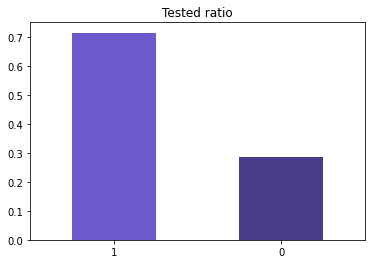

In [78]:
DF['Tested'].value_counts(normalize=True).plot(kind='bar', title = 'Tested ratio', rot=0, color=['slateblue', 'darkslateblue'])
plt.show()